{/* cspell:ignore ebit operatorname */}



# Qiskit implementation: teleportation

Source: https://quantum.cloud.ibm.com/learning/en/courses/basics-of-quantum-information/entanglement-in-action/qiskit-implementation

Walkthrough: https://quantum.cloud.ibm.com/learning/en/courses/basics-of-quantum-information/entanglement-in-action/quantum-teleportation

In this lesson, we implement some of the ideas from the lesson on entanglement in action, using Qiskit. 



In [1]:
from qiskit import __version__

print(__version__)

2.2.1


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

Here is a quantum circuit implementation of the teleportation protocol.



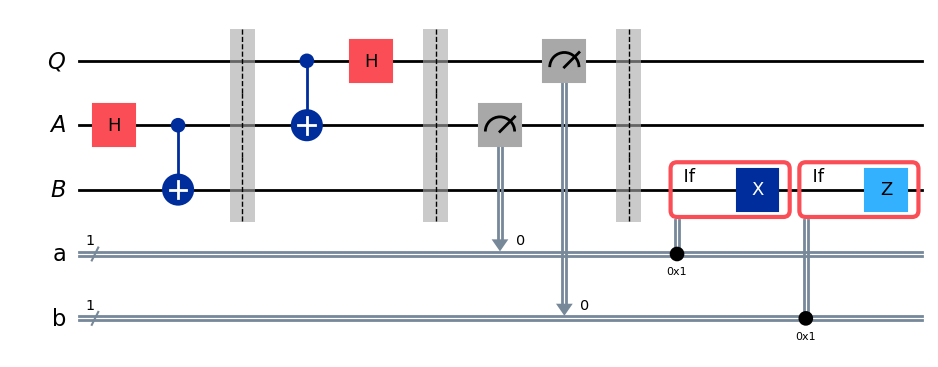

In [3]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw(output="mpl"))

The circuit makes use of a few features of Qiskit that we've not yet seen in previous lessons, including the `barrier` and `if_test` functions.
The `barrier` function creates a visual separation making the circuit diagram more readable, and it also prevents Qiskit from performing various simplifications and optimizations across the barrier during compilation when circuits are run on real hardware.
The `if_test` function applies an operation conditionally depending on a classical bit or register.

The circuit first initializes $(\mathsf{A},\mathsf{B})$ to be in a $\vert \phi^+\rangle$ state (which is not part of the protocol itself), followed by Alice's operations, then her measurements, and finally Bob's operations.
To test that the protocol works correctly, we'll apply a randomly generated single-qubit gate to the initialized $\vert 0\rangle$ state of $\mathsf{Q}$ to obtain a random quantum state vector to be teleported. By applying the inverse (as in, the conjugate transpose) of that gate to $\mathsf{B}$ after the protocol is run, we can verify that the state was teleported by measuring to see that it has returned to the $\vert 0\rangle$ state.

First we'll randomly choose a unitary qubit gate.



In [4]:
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi,
)

display(array_to_latex(random_gate.to_matrix()))

<IPython.core.display.Latex object>

Now we'll create a new testing circuit that first applies our random gate to $\mathsf{Q},$ then runs the teleportation circuit, and finally applies the inverse of our random gate to the qubit $\mathsf{B}$ and measures.
The outcome should be $0$ with certainty.



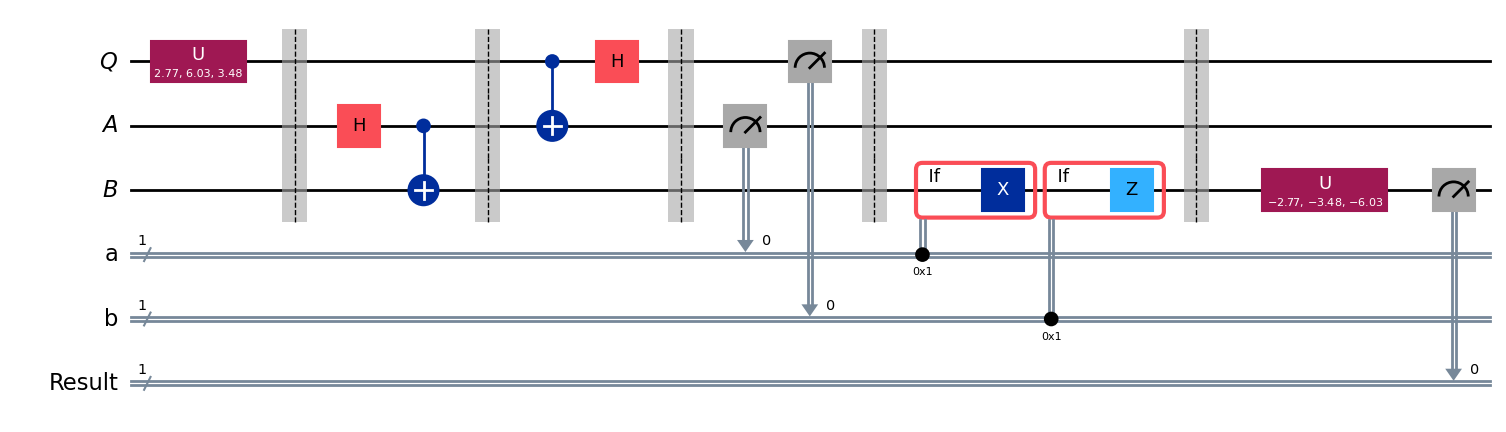

In [5]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q

test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above.

test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure.

test.append(random_gate.inverse(), ebit1)
result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw(output="mpl"))

Finally, let's run the Aer simulator on this circuit and plot a histogram of the outputs.
We'll see the statistics for all three classical bits:
the bottom/leftmost bit should always be $0,$ indicating that the qubit $\mathsf{Q}$ was successfully teleported into $\mathsf{B},$ while the other two bits should be roughly uniform.



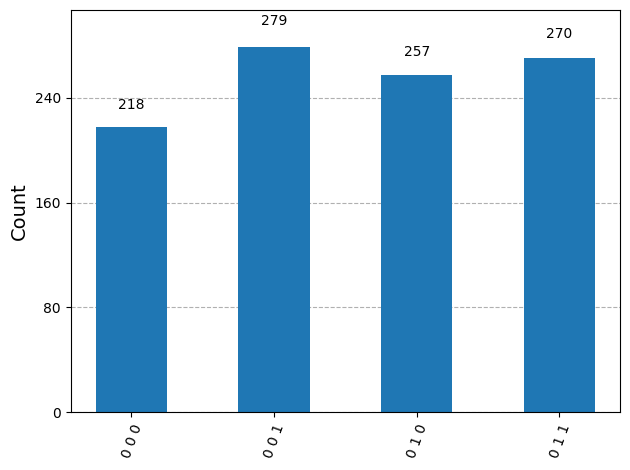

In [6]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

We can also filter the statistics to focus solely on the test result qubit if we wish, like this:



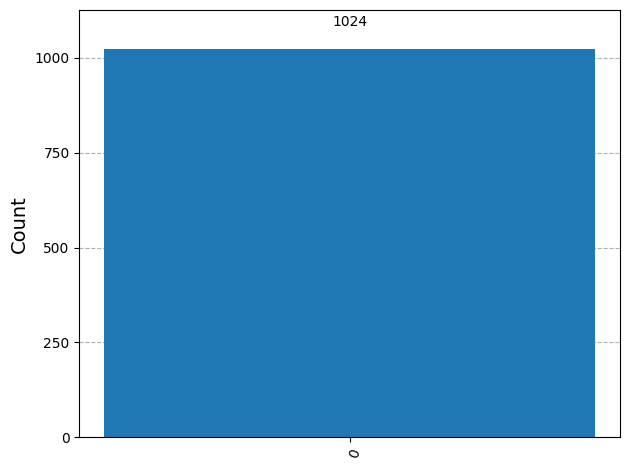

In [7]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

© IBM Corp., 2017-2025